In [ ]:
%matplotlib inline
import os
import time
import tqdm
import torch
import numpy as np
import pandas as pd
from PIL import Image
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision import models, transforms
from torch.utils.data import TensorDataset,DataLoader , Dataset
import cv2

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_csv = pd.read_csv('/content/drive/MyDrive/kursinis/steel/train.csv')
train_csv.head(10)

,ImageId,ClassId,EncodedPixels
0,0002cc93b.jpg,1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
1,0007a71bf.jpg,3,18661 28 18863 82 19091 110 19347 110 19603 11...
2,000a4bcdd.jpg,1,37607 3 37858 8 38108 14 38359 20 38610 25 388...
3,000f6bf48.jpg,4,131973 1 132228 4 132483 6 132738 8 132993 11 ...
4,0014fce06.jpg,3,229501 11 229741 33 229981 55 230221 77 230468...
5,0025bde0c.jpg,3,8458 14 8707 35 8963 48 9219 71 9475 88 9731 8...
6,0025bde0c.jpg,4,315139 8 315395 15 315651 16 315906 17 316162 ...
7,002af848d.jpg,4,290800 6 291055 13 291311 15 291566 18 291822 ...
8,002fc4e19.jpg,1,146021 3 146275 10 146529 40 146783 46 147038 ...
9,002fc4e19.jpg,2,145658 7 145901 20 146144 33 146386 47 146629 ...


In [ ]:
train_df = train_csv.dropna(subset=['EncodedPixels'], axis='rows', inplace=True)

train_df = (
    train_csv[['ImageId', 'ClassId', 'EncodedPixels']]
        .groupby('ImageId', as_index=False) 
        .agg(list) 
)
train_df.head(10)

,ImageId,ClassId,EncodedPixels
0,0002cc93b.jpg,[1],[29102 12 29346 24 29602 24 29858 24 30114 24 ...
1,0007a71bf.jpg,[3],[18661 28 18863 82 19091 110 19347 110 19603 1...
2,000a4bcdd.jpg,[1],[37607 3 37858 8 38108 14 38359 20 38610 25 38...
3,000f6bf48.jpg,[4],[131973 1 132228 4 132483 6 132738 8 132993 11...
4,0014fce06.jpg,[3],[229501 11 229741 33 229981 55 230221 77 23046...
5,0025bde0c.jpg,"[3, 4]",[8458 14 8707 35 8963 48 9219 71 9475 88 9731 ...
6,002af848d.jpg,[4],[290800 6 291055 13 291311 15 291566 18 291822...
7,002fc4e19.jpg,"[1, 2]",[146021 3 146275 10 146529 40 146783 46 147038...
8,0030401a5.jpg,[4],[186833 1 187089 3 187344 6 187600 7 187855 10...
9,0046839bd.jpg,[3],[152926 1 153180 4 153434 6 153689 8 153943 11...


In [ ]:
train_df

,ImageId,ClassId,EncodedPixels
0,0002cc93b.jpg,[1],[29102 12 29346 24 29602 24 29858 24 30114 24 ...
1,0007a71bf.jpg,[3],[18661 28 18863 82 19091 110 19347 110 19603 1...
2,000a4bcdd.jpg,[1],[37607 3 37858 8 38108 14 38359 20 38610 25 38...
3,000f6bf48.jpg,[4],[131973 1 132228 4 132483 6 132738 8 132993 11...
4,0014fce06.jpg,[3],[229501 11 229741 33 229981 55 230221 77 23046...
...,...,...,...
6661,ffcf72ecf.jpg,[3],[121911 34 122167 101 122422 169 122678 203 12...
6662,fff02e9c5.jpg,[3],[207523 3 207777 9 208030 15 208283 22 208537 ...
6663,fffe98443.jpg,[3],[105929 5 106177 14 106424 24 106672 33 106923...
6664,ffff4eaa8.jpg,[3],[16899 7 17155 20 17411 34 17667 47 17923 60 1...


In [ ]:
def rle2mask(idx,df):
    img_name = df.iloc[idx , 0]
    
    labels = df.iloc[idx , 2]
    mask = np.zeros((256,1600,4) , dtype = np.uint8)
    cl = df.iloc[idx , 1]
    for i,label in enumerate(labels): 
        
        runss = np.asarray([int(x) for x in label.split(' ')])
        runss[1::2] += runss[0::2]
        runss -= 1
        run_starts, run_ends = runss[0::2], runss[1::2]
        h, w = (1600,256)
        mask_label = np.zeros(h*w, dtype=np.uint8)
        for start, end in zip(run_starts, run_ends):
            mask_label[start:end] = 1
    
        mask[:,:,cl[i]-1] = mask_label.reshape(256,1600,order = 'F')
    return img_name , mask    

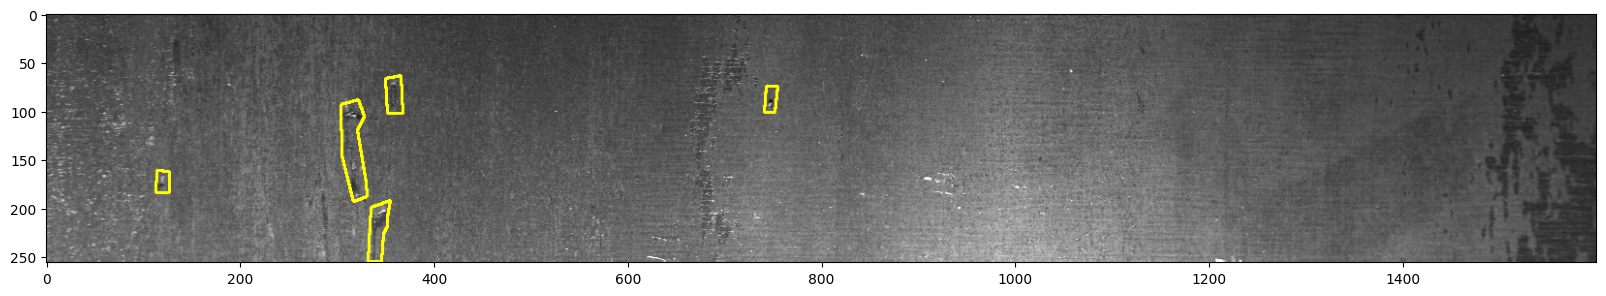

In [ ]:
for i in range(1):
    plt.figure(figsize=(20,10))
    img_name , mask = rle2mask(i,train_df)
    img = cv2.imread('/content/drive/MyDrive/kursinis/steel/train_images' + '/' + img_name)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    for ch in range(4):
        contours, hierarchy = cv2.findContours(mask[:,:,ch], cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        cv2.drawContours(img, contours, -1, (255,255,0), 2)
    plt.imshow(img)

In [ ]:
class SteelDataset(Dataset):
    def __init__(self,df , path):
        self.df = df
        self.path = path
    
    def __getitem__(self,index):
        img_name , mask = rle2mask(index,self.df)
        img_path = os.path.join(self.path , img_name)
        img = cv2.imread(img_path)
        img = np.array(img)/255
        img = torch.from_numpy(img).permute(2,0,1)
        mask = torch.from_numpy(mask).permute(2,0,1)
        return img,mask
    
    def __len__(self):
        return len(self.df)

In [ ]:
use_gpu = torch.cuda.is_available()
if use_gpu:
    print('GPU is available')
    device = "cuda"
    pinMem = True
else:
    print('GPU is not available')
    device = "cpu"
    pinMem = False

GPU is available!


In [ ]:
trainpath = '/content/drive/MyDrive/kursinis/steel/train_images'
trainDataset = SteelDataset(train_df.iloc[:int(0.8*len(train_df))] ,trainpath )
valDataset = SteelDataset(train_df.iloc[int(0.8*len(train_df)):] ,trainpath )
batch_size = 16

trainDataLoader = DataLoader(trainDataset , batch_size = batch_size , shuffle = True, num_workers=2,pin_memory =True)
valDataLoader = DataLoader(valDataset, batch_size = batch_size, shuffle = True , num_workers = 2, pin_memory=True)

In [ ]:
!pip install segmentation-models-pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 8.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 kB 49.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 24.3 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16427 sha256=f86c13b83e3a496a1b2746d29cddea026c0d6c8ab288078b829ccb4e8974bba0
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=a360876f8db3f57afc7dc074b790c7cbb394839d5f4e6e38204fcf0c2db06b30
  Stored in directory: /root/.cache/pip/w

In [ ]:
#https://pypi.org/project/segmentation-models-pytorch/
import segmentation_models_pytorch as smp
from segmentation_models_pytorch import PSPNet


In [ ]:
model = PSPNet(encoder_name='tu-mobilevitv2_150' , encoder_weights = 'imagenet' , classes=4 , activation = 'sigmoid')
mode = model.to(device)
print(model)

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-mvit-weights/mobilevitv2_150-737c5019.pth" to /root/.cache/torch/hub/checkpoints/mobilevitv2_150-737c5019.pth


PSPNet(
  (encoder): TimmUniversalEncoder(
    (model): FeatureListNet(
      (stem): ConvNormAct(
        (conv): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNormAct2d(
          48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
      )
      (stages_0): Sequential(
        (0): BottleneckBlock(
          (conv1_1x1): ConvNormAct(
            (conv): Conv2d(48, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn): BatchNormAct2d(
              96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
              (drop): Identity()
              (act): SiLU(inplace=True)
            )
          )
          (conv2_kxk): ConvNormAct(
            (conv): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=96, bias=False)
            (bn): BatchNormAct2d(
              96, eps=1e-05, momentum=0.1, affi

In [ ]:
def dice_coef(y_pred,y_true,smooth=1):
    y_pred = y_pred.view(batch_size,-1)
    y_true = y_true.view(batch_size,-1)
    y_pred = (y_pred > 0.5).float()
    y_true = (y_true > 0.5).float()
    dice = (2* torch.sum(y_pred*y_true)+smooth)/(torch.sum(y_pred)+torch.sum(y_true)+smooth)
    dice = torch.mean(dice , axis=0)
    return dice

In [ ]:
def f1_score(y_pred, y_true, smooth=1):
    y_pred = y_pred.view(batch_size, -1)
    y_true = y_true.view(batch_size, -1)
    y_pred = (y_pred > 0.5).float()
    y_true = (y_true > 0.5).float()
    tp = torch.sum(y_true * y_pred)
    fp = torch.sum((1 - y_true) * y_pred)
    fn = torch.sum(y_true * (1 - y_pred))
    precision = tp / (tp + fp + smooth)
    recall = tp / (tp + fn + smooth)
    f1 = 2 * precision * recall / (precision + recall + smooth)
    f1 = torch.mean(f1, axis=0)
    return f1

In [ ]:
def intersection_over_union(y_pred, y_true, smooth=1):
    y_pred = y_pred.view(batch_size, -1)
    y_true = y_true.view(batch_size, -1)
    y_pred = (y_pred > 0.5).float()
    y_true = (y_true > 0.5).float()
    intersection = torch.sum(y_true * y_pred)
    union = torch.sum(y_true) + torch.sum(y_pred) - intersection
    iou = (intersection + smooth) / (union + smooth)
    iou = torch.mean(iou, axis=0)
    return iou

In [ ]:
criterion = nn.BCELoss() 
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
iterations = 2
trainLoss = []
valLoss = []
valDice = []
valF1 = []
valIou = []
start = time.time()

for epoch in range(iterations):
    epochStart = time.time()
    runningLoss = 0   
    model.train() # For training
    for data in tqdm.notebook.tqdm(trainDataLoader):
        inputs,labels = data
        inputs, labels = inputs.float().to(device), labels.float().to(device) 
        
        # Feed-forward input data through the network
        outputs = model(inputs)
        # Compute loss/error
        loss = criterion(outputs, labels)      
        # Initialize gradients to zero
        optimizer.zero_grad()                  
        # Backpropagate loss and compute gradients
        loss.backward()
        # Update the network parameters
        optimizer.step()
        # Accumulate loss per batch
        runningLoss += loss.item()
    avgTrainLoss = runningLoss/(5332 /batch_size)   
    trainLoss.append(avgTrainLoss)
  
    
    # Evaluating performance on test set for each epoch
    model.eval() # For testing
    val_runningLoss = 0
    val_runningDice = 0
    val_runningF1 = 0
    val_runningIou = 0
    with torch.no_grad():
        for data in tqdm.notebook.tqdm(valDataLoader):
            inputs,labels = data
            inputs, labels = inputs.float().to(device), labels.float().to(device)         
            outputs = model(inputs)       
             # Compute loss/error
            loss = criterion(outputs, labels)      
            # Accumulate loss per batch
            val_runningLoss += loss.item() 
            val_runningDice += dice_coef(outputs,labels)
            val_runningF1 += f1_score(outputs,labels)
            val_runningIou += intersection_over_union(outputs,labels)
    avgValLoss = val_runningLoss/(1334/batch_size)  
    valLoss.append(avgValLoss)
    avgValDice = (val_runningDice/(1334/batch_size)).cpu()  
    valDice.append(avgValDice)
    avgValF1 = (val_runningF1/(1334/batch_size)).cpu()  
    valF1.append(avgValF1)
    avgValIou = (val_runningIou/(1334/batch_size)).cpu()  
    valIou.append(avgValIou)
    # Plotting Loss vs Epochs
    fig1 = plt.figure(1)        
    plt.plot(range(epoch+1),trainLoss,'r--',label='train')        
    plt.plot(range(epoch+1),valLoss,'g--',label='valid')        
    if epoch==0:
        plt.legend(loc='upper left')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')   
    fig2 = plt.figure(2)        
    plt.plot(range(epoch+1),valDice,'g-',label='valid')        
    if epoch==0:
        plt.legend(loc='upper left')
        plt.xlabel('Epochs')
        plt.ylabel('dice_coef')   
    fig3 = plt.figure(3)        
    plt.plot(range(epoch+1),valF1,'g-',label='valid')        
    if epoch==0:
        plt.legend(loc='upper left')
        plt.xlabel('Epochs')
        plt.ylabel('F1_score')  
    fig4 = plt.figure(4)        
    plt.plot(range(epoch+1),valIou,'g-',label='valid')        
    if epoch==0:
        plt.legend(loc='upper left')
        plt.xlabel('Epochs')
        plt.ylabel('IoU')  
    
    epochEnd = time.time()-epochStart
    print('At Iteration: {:.0f} /{:.0f}  ;  Training Loss: {:.6f}; Time consumed: {:.0f}m {:.0f}s '\
          .format(epoch + 1,iterations,avgTrainLoss,epochEnd//60,epochEnd%60))
    print('At Iteration: {:.0f} /{:.0f}  ;  Validation Loss: {:.6f} ; Validation Dice: {:.3f}; Validation F1: {:.3f}; Validation IoU: {:.3f}; Time consumed: {:.0f}m {:.0f}s '\
          .format(epoch + 1,iterations,avgValLoss,avgValDice,avgValF1, avgValIou, epochEnd//60,epochEnd%60))
end = time.time()-start
print('Training completed in {:.0f}m {:.0f}s'.format(end//60,end%60))

In [ ]:
torch.save(model.state_dict(), 'unetresnet18_adam.pt')

In [ ]:
torch.cuda.empty_cache()

In [ ]:
model.load_state_dict(torch.load('/content/PSPNETMOBILE'))

<All keys matched successfully>

In [ ]:
testpath = '/content/drive/MyDrive/kursinis/steel/test_images'
images = os.listdir('/content/drive/MyDrive/kursinis/steel/test_images')
test_df = pd.read_csv('/content/drive/MyDrive/kursinis/steel/sample_submission.csv')
test_df['ImageId'] = images
test_df

,ImageId,EncodedPixels,ClassId
0,d42d5725e.jpg,1 409600,0
1,dab41427c.jpg,1 409600,0
2,dc2389797.jpg,1 409600,0
3,d5137b6f8.jpg,1 409600,0
4,da2e43f73.jpg,1 409600,0
...,...,...,...
5501,1eb204d65.jpg,1 409600,0
5502,1ed7c09f2.jpg,1 409600,0
5503,1d69e0984.jpg,1 409600,0
5504,16c79808e.jpg,1 409600,0


In [ ]:
class TestDataset(Dataset):
    def __init__(self,df , path):
        self.df = df
        self.path = path
    
    def __getitem__(self,index):
        img_name = self.df.iloc[index,0]
        img_path = os.path.join(self.path , img_name)
        img = cv2.imread(img_path)
        img = np.array(img)/255
        img = torch.from_numpy(img).permute(2,0,1)
        return img , img_name
    
    def __len__(self):
        return len(self.df)

In [ ]:
testDataset = TestDataset(test_df , testpath)
testDataLoader = DataLoader(testDataset, batch_size = 8, shuffle = False , num_workers = 2, pin_memory=True)

In [ ]:
#https://www.kaggle.com/paulorzp/rle-functions-run-lenght-encode-decode
def mask2rle(img):
    img = img.flatten()
    img = np.concatenate([[0],img ,[0]])
    runs = np.where(img[1:] != img[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [ ]:
threshold_min = [0.7,0.7,0.7,0.7]
thresholds_max=[0.7,0.7,0.7,0.7]
thresholds_min=[0.2,0.2,0.3,0.3]
min_area=[350, 500, 750, 1000]
res = []
model.eval()
for data in tqdm.notebook.tqdm(testDataLoader):
    inputs , img_names = data
    inputs = inputs.float().to(device)
    preds = model(inputs)
    
    for pred,file in zip(preds,img_names):
        file = os.path.basename(file)
        
        for i in range(4):
            p_channel = pred[i]
            p_channel_ = p_channel
            imageid_classid = file+'_'+str(i+1)
            p_channel = (p_channel>thresholds_max[i]).cpu().numpy().astype(np.uint8)
            if p_channel.sum() < min_area[i]:
                p_channel = np.zeros(p_channel.shape, dtype=p_channel.dtype)
            else:
                p_channel = (p_channel_>thresholds_min[i]).cpu().numpy().astype(np.uint8)
            res.append({
                'ImageId_ClassId': imageid_classid,
                'EncodedPixels': mask2rle(p_channel)
            })

submit_df = pd.DataFrame(res)            
    